In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import os
import random

In [165]:
parent_folder = os.path.dirname(os.getcwd())
sibling_folder = os.path.join(parent_folder,'data')
processed_folder = os.path.join(sibling_folder, 'processed')

In [166]:
feather_file1 = os.path.join(processed_folder, 'icu_timeseries_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather')
feather_file2 = os.path.join(processed_folder, 'icu_tabular_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather')
df1 = feather.read_feather(feather_file1)
df1 = df1[['abs_event_time', 'stay_id', 'Arterial Blood Pressure mean','Sodium','Potassium','Creatinine','GCS - Eye Opening','GCS - Motor Response','GCS - Verbal Response']]
df2= feather.read_feather(feather_file2)
df2 = df2[['anchor_age', 'stay_id']]
merged_df = pd.merge(df1, df2, on='stay_id')
merged_df['abs_event_time'] = pd.to_datetime(merged_df['abs_event_time'])

In [167]:

def calculate_APACHE_II(row):
    anchor_age = row['anchor_age']
    bp_mean = row['Arterial Blood Pressure mean']
    sodium = row['Sodium']
    potassium = row['Potassium']
    creatinine = row['Creatinine']
    eye_opening = row['GCS - Eye Opening']
    motor_response = row['GCS - Motor Response']
    verbal_response = row['GCS - Verbal Response']

    # Age points
    age_points = lambda x: (
        6 if x >= 75 else
        5 if 65 <= x < 75 else
        3 if 55 <= x < 65 else
        2 if 45 <= x < 55 else
        0
    )

    # Arterial blood pressure
    bp_points = lambda x: (
        4 if x >= 160 or x < 50 else
        3 if 130 <= x < 160 else
        2 if (110 <= x < 130) or (50 <= x < 70) else
        0 if 70 <= x < 110 else
        2
    )

    # Serum Sodium
    sodium_points = lambda x: (
        4 if x >= 180 or x <= 110 else
        3 if (160 <= x < 180) or (110 < x < 120) else
        2 if (155 <= x < 160) or (120 <= x < 130) else
        1 if 150 <= x < 155 else
        0 if 130 <= x < 150 else
        0
    )

    # Serum Potassium
    potassium_points = lambda x: (
        4 if x >= 7.0 or x < 2.5 else
        3 if 6.0 <= x < 7.0 else
        2 if 2.5 <= x < 3.0 else
        1 if (5.5 <= x < 6.0) or (3.0 <= x < 3.5) else
        0 if 3.5 <= x < 5.5 else
        0
    )

    # Serum Creatinine
    creatinine_points = lambda x: (
        4 if x >= 3.5 else
        3 if 2.0 <= x < 3.5 else
        2 if (1.5 <= x < 2.0) or (x < 0.6) else
        0 if 0.6 <= x < 1.5 else
        0
    )
    gcs_points = lambda eye, motor, verbal: 15 - (eye + motor + verbal)

    age_pts = age_points(anchor_age)
    bp_pts = bp_points(bp_mean)
    sodium_pts = sodium_points(sodium)
    potassium_pts = potassium_points(potassium)
    creatinine_pts = creatinine_points(creatinine)
    gcs_pts = gcs_points(eye_opening, motor_response, verbal_response)

    APACHE_score = age_pts + bp_pts + sodium_pts + potassium_pts + creatinine_pts + gcs_pts

    return APACHE_score

In [168]:
def calculate_mortality_apache(APACHE_score):
    logit = -3.517 + 0.146 * APACHE_score * np.log(APACHE_score + 1)
    mortality = np.exp(logit) / (1 + np.exp(logit))
    return mortality

In [169]:
low_threshold = 10
high_threshold = 22
merged_df_ffilled = merged_df.ffill()
merged_df_filled = merged_df_ffilled.bfill()
merged_df_filled['APACHE_score'] = merged_df_filled.apply(calculate_APACHE_II, axis=1)
merged_df_filled['mortality'] = merged_df_filled.apply(lambda row: calculate_mortality_apache(row['APACHE_score']), axis=1)
random_stay_id = random.choice(merged_df_filled['stay_id'])
random_df = merged_df_filled[merged_df_filled['stay_id'] == random_stay_id]
random_df_copy = random_df.copy()
bins = [-float('inf'), low_threshold, high_threshold, float('inf')]
labels = ['Low', 'Moderate', 'High']
random_df_copy.loc[:, 'score_category'] = pd.cut(random_df_copy['APACHE_score'], bins=bins, labels=labels, right=False)

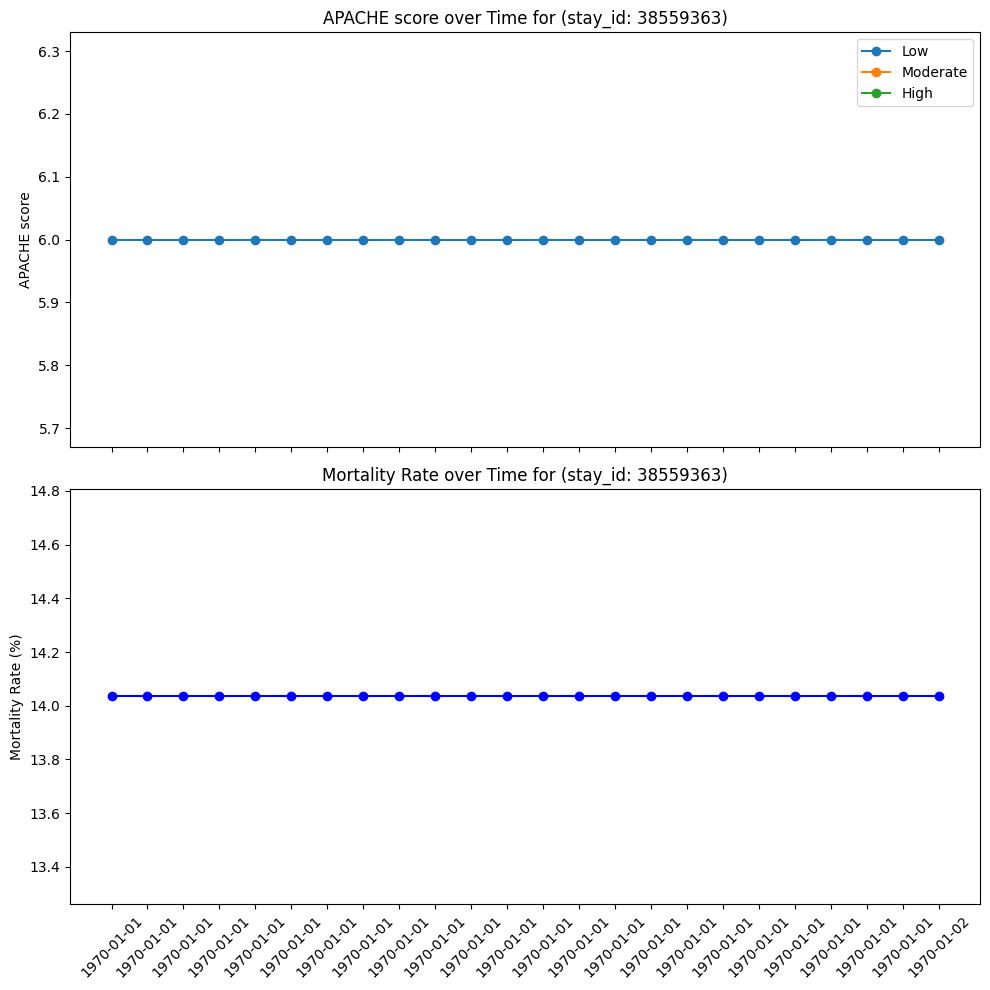

In [170]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

for category, group in random_df_copy.groupby('score_category', observed=False):
    ax1.plot(group['abs_event_time'], group['APACHE_score'], marker='o', linestyle='-', label=category)
ax1.set_ylabel('APACHE score')
ax1.set_title('APACHE score over Time for (stay_id: {})'.format(random_stay_id))
ax1.legend()
ax1.set_xticks(random_df_copy['abs_event_time'])
ax1.xaxis.set_tick_params(rotation=45) 

ax2.plot(random_df_copy['abs_event_time'], random_df_copy['mortality'] * 100, marker='o', linestyle='-', color='blue')
ax2.set_ylabel('Mortality Rate (%)')
ax2.set_title('Mortality Rate over Time for (stay_id: {})'.format(random_stay_id))
ax2.set_xticks(random_df_copy['abs_event_time'])
ax2.xaxis.set_tick_params(rotation=45)  

plt.tight_layout() 
plt.show()
